In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

In [25]:
df_filepath = "..\\dataset\\new dataset.xlsx"
df = pd.read_excel(df_filepath)
print(df.head())

   Year  Month  Day Weekend?    Hour Collision Type         Injury Type  \
0  2015      1    5  Weekday     0.0          2-Car   No injury/unknown   
1  2015      1    6  Weekday  1500.0          2-Car   No injury/unknown   
2  2015      1    6  Weekend  2300.0          2-Car  Non-incapacitating   
3  2015      1    7  Weekend   900.0          2-Car  Non-incapacitating   
4  2015      1    7  Weekend  1100.0          2-Car   No injury/unknown   

                          Primary Factor      Reported_Location   Latitude  \
0  OTHER (DRIVER) - EXPLAIN IN NARRATIVE             1ST & FESS  39.159207   
1                  FOLLOWING TOO CLOSELY          2ND & COLLEGE  39.161440   
2              DISREGARD SIGNAL/REG SIGN  BASSWOOD & BLOOMFIELD  39.149780   
3          FAILURE TO YIELD RIGHT OF WAY         GATES & JACOBS  39.165655   
4          FAILURE TO YIELD RIGHT OF WAY                  W 3RD  39.164848   

   Longitude  
0 -86.525874  
1 -86.534848  
2 -86.568890  
3 -86.575956  
4 -86

# df Cleaning
**Feature Selection**
Provided columns are 'Year', 'Month', 'Day', 'Weekend?', 'Hour', 'Collision Type', 'Injury Type','Primary Factor', 'Reported_Location', 'Latitude', 'Longitude'. We drop features that are not useable for our model.

**Removing Rows with Empty Values**
We will also drop any rows with empty values in the selected features

In [26]:
df = df.drop(columns=['Primary Factor', 'Year'])
df = df.dropna()
print(df.head())

   Month  Day Weekend?    Hour Collision Type         Injury Type  \
0      1    5  Weekday     0.0          2-Car   No injury/unknown   
1      1    6  Weekday  1500.0          2-Car   No injury/unknown   
2      1    6  Weekend  2300.0          2-Car  Non-incapacitating   
3      1    7  Weekend   900.0          2-Car  Non-incapacitating   
4      1    7  Weekend  1100.0          2-Car   No injury/unknown   

       Reported_Location   Latitude  Longitude  
0             1ST & FESS  39.159207 -86.525874  
1          2ND & COLLEGE  39.161440 -86.534848  
2  BASSWOOD & BLOOMFIELD  39.149780 -86.568890  
3         GATES & JACOBS  39.165655 -86.575956  
4                  W 3RD  39.164848 -86.579625  


# Normalizing Data
**Normalizing Hours**

Disregarding decimal points, Hour values are currently 3-4 characters with the least significant 2 digits being minutes (always 00 in this dataset) and the remaining significant bits denoting hours. We will remove decimal point and remove minutes integers so that the only remaining number is what number hour it is (from 0 to 23).

In [27]:
# We must normalize all values in hour column such that it is 4 integers indicating the format (HH:MM)
df['Hour'] = df['Hour'].astype(int).astype(str).str.zfill(4)

# get just the HH values (indicates which of the 24 buckets the value goes into)
df['Hour'] = df['Hour'].str[:2].astype(int)

**Encoding Weekend**

Encode "yes weekend" to 1 and "no weekend" to 0 so we can use this feature in our neural network

In [28]:
weekend_mapping = {'Weekday':0, 'Weekend':1}
df['Weekend?'] = df['Weekend?'].replace(weekend_mapping)
print(df.head())

   Month  Day  Weekend?  Hour Collision Type         Injury Type  \
0      1    5         0     0          2-Car   No injury/unknown   
1      1    6         0    15          2-Car   No injury/unknown   
2      1    6         1    23          2-Car  Non-incapacitating   
3      1    7         1     9          2-Car  Non-incapacitating   
4      1    7         1    11          2-Car   No injury/unknown   

       Reported_Location   Latitude  Longitude  
0             1ST & FESS  39.159207 -86.525874  
1          2ND & COLLEGE  39.161440 -86.534848  
2  BASSWOOD & BLOOMFIELD  39.149780 -86.568890  
3         GATES & JACOBS  39.165655 -86.575956  
4                  W 3RD  39.164848 -86.579625  


**Encoding Injury**

Encode there being an injury to a 1 and no injury to a 0 so we can classify if there's likely an injury.

In [29]:
injury_mapping = {'No injury/unknown' : 0,
                  'Non-incapacitating' : 1,
                  'Incapacitating': 2,
                  'Fatal' : 3}
df['Injury Type'] = df['Injury Type'].replace(injury_mapping)

**Encoding Collision Type**

In [30]:
print(df['Collision Type'].unique())

# numbering chosen in order of, intuitively, most dangerous to least
collision_encoding = {'2-Car' : 4,
                      '1-Car' : 5,
                      '3+ Cars' : 3,
                      'Pedestrian' : 0,
                      'Cyclist' : 1,
                      'Bus' : 6,
                      'Moped/Motorcycle' : 2}
df['Collision Type'] = df['Collision Type'].replace(collision_encoding)

['2-Car' '1-Car' '3+ Cars' 'Pedestrian' 'Cyclist' 'Bus' 'Moped/Motorcycle']


# Finding Outliers

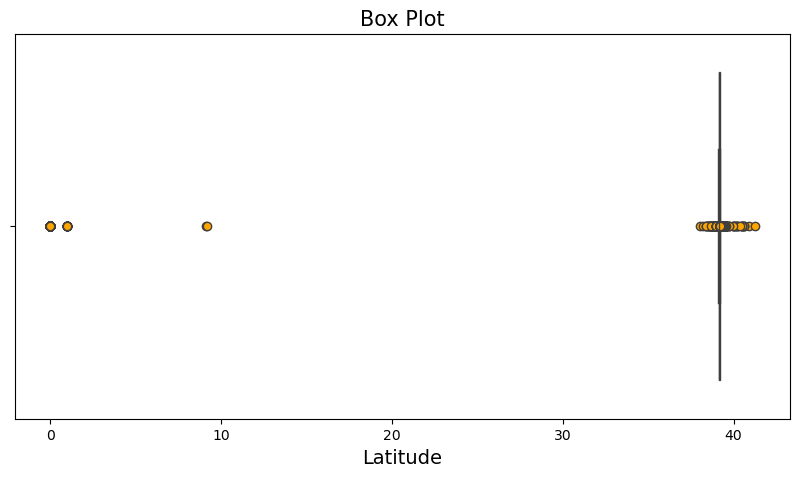

0.0 41.22866547


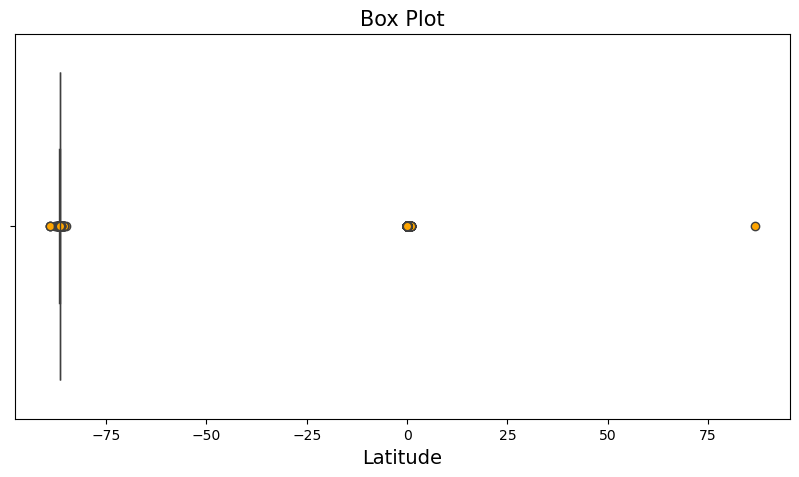

0.0 41.22866547


In [31]:
fig = plt.figure(figsize=(10,5))
sns.boxplot(x = df['Latitude'], flierprops = dict(markerfacecolor = 'orange', marker = 'o'))
plt.title('Box Plot', fontsize=15)
plt.xlabel('Latitude', fontsize=14)
plt.show()

print(df['Latitude'].min(), df['Latitude'].max())

fig = plt.figure(figsize=(10,5))
sns.boxplot(x = df['Longitude'], flierprops = dict(markerfacecolor = 'orange', marker = 'o'))
plt.title('Box Plot', fontsize=15)
plt.xlabel('Latitude', fontsize=14)
plt.show()
print(df['Latitude'].min(), df['Latitude'].max())

In [32]:
mean_longitude = df['Longitude'].mean()
std_longitude = df['Longitude'].std()
threshold = 2 * std_longitude

# Create a boolean mask to identify rows where "Longitude" is within the threshold
mask = (df['Longitude'] >= (mean_longitude - threshold)) & (df['Longitude'] <= (mean_longitude + threshold))
# apply mask
filtered_df = df[mask]

mean_latitude = df['Latitude'].mean()
std_latitude = df['Latitude'].std()
threshold = 2 * std_latitude

# Create a boolean mask to identify rows where "Longitude" is within the threshold
mask = (filtered_df['Latitude'] >= (mean_latitude - threshold)) & (filtered_df['Latitude'] <= (mean_latitude + threshold))
# apply mask
filtered_df = filtered_df[mask]

print(df.shape)
# Print the filtered DataFrame
print(filtered_df.shape)

(53654, 9)
(48775, 9)


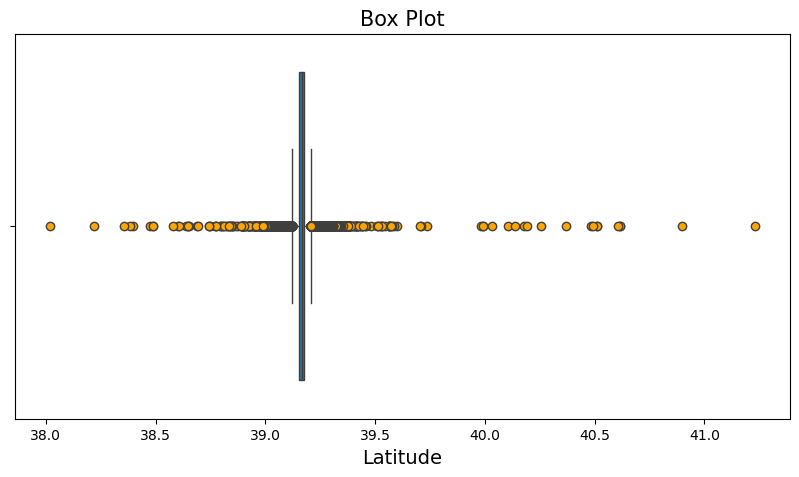

38.01932812 41.22866547


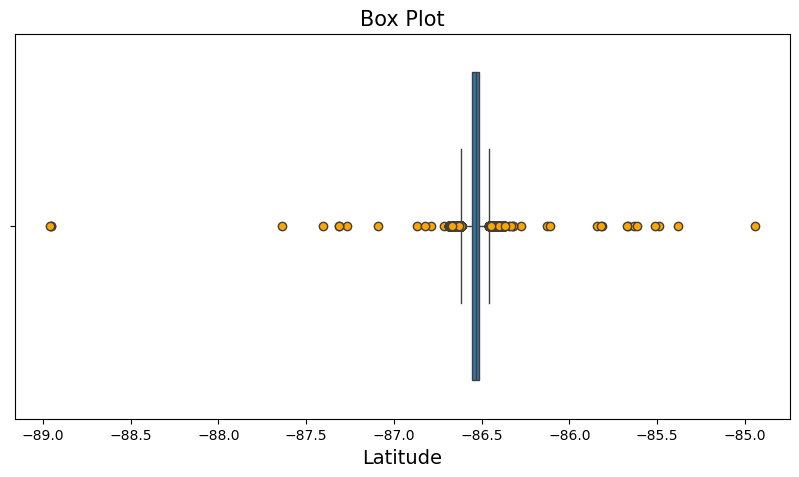

38.01932812 41.22866547


In [34]:
fig = plt.figure(figsize=(10,5))
sns.boxplot(x = filtered_df['Latitude'], flierprops = dict(markerfacecolor = 'orange', marker = 'o'))
plt.title('Box Plot', fontsize=15)
plt.xlabel('Latitude', fontsize=14)
plt.show()

print(filtered_df['Latitude'].min(), filtered_df['Latitude'].max())

fig = plt.figure(figsize=(10,5))
sns.boxplot(x = filtered_df['Longitude'], flierprops = dict(markerfacecolor = 'orange', marker = 'o'))
plt.title('Box Plot', fontsize=15)
plt.xlabel('Latitude', fontsize=14)
plt.show()
print(filtered_df['Latitude'].min(), filtered_df['Latitude'].max())

# Save Modified Data

Will save modified data to a CSV file for use by our model

In [33]:
filtered_df.to_csv('.\\modified_data\\cleaned_data.csv', index=False)